## Algoritmo genético
Se cambia el método de crossover para no agregar tantos términos extras.

In [151]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, simplify
import time
import copy


In [152]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


Se minimiza $$\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$$ con el objetivo de obtener la función $f(x)$ que mejor se ajuste a los datos.


In [153]:
def polix(x):
    return x**x
def poli1(x):
    return (x+1) 
def poli2(x):
    return x**2
def poli3(x):
    return x**3

# Crear lista con coeficientes
coeficientes = [random.random() for i in range(5)]
# Crear lista de funciones
funciones_c = [lambda x, i=i: coeficientes[i] for i in range(5)]


grammar = [polix, poli1, poli2, poli3] + funciones_c
operaciones = ['+', '-', '*', '/']


#A partir de las funciones ingresadas inicialmente, calcula el chi_2
def chi_2_valores(f):
    return np.square((H - f(z))/desv)

def chi_2_f(f):
    chi_2_val = np.zeros_like(f)
    chi_2 = np.zeros_like(f)
    for i in range(len(f)):
        chi_2_val[i] = chi_2_valores(f[i])
        for j in range(len(chi_2_val)):
            chi_2[j] = np.sum(chi_2_val[j])
    
    return chi_2

#print(chi_2_f(grammar))
#chi_inic = chi_2_f(grammar)

### Combinar la función inicial
Se combinan las funciones iniciales con operaciones entre ellas hasta que haya una cantidad definida de funciones iniciales.
Se tomaron 50 funciones iniciales debido a que aumentará la cantidad de individuos a medida en que se realiza crossover y mutación a las funciones iniciales.

In [154]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=100):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    # Crear una lista de sublistas para representar las filas
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

resultado_final_inicial = juntar_elementos_inicial(grammar, operaciones)
#for fila in resultado_final_inicial:
#    print(fila)


### Convertir la lista a función
Se definen funciones para para convertir una lista de funciones y strings (operaciones) en una función.

In [155]:

#x deben estar entre paréntesis para no confundir con otros x en el string
def a_string(funcion):
    if funcion == polix:
        return '(x)**(x)'
    elif funcion == poli1:
        return '((x)+1)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    for i in range(len(funciones_c)):
        if funcion == funciones_c[i]:
            return str(coeficientes[i])
    else:
        return str(funcion)

x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    #if len(expresion)>= 30:
        # Simplificar la expresión
        #a_sympy = simplify(a_sympy)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

#print(pasar_a_funcion('exp(x**2)'))(2)
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int


def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-',poli1, poli2, funciones_c[0] ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func

#print(convertir_lista_a_funcion(lista_prueba))


### Calcular los $\chi^2$ de la población inicial y seleccionar las mejores funciones

In [156]:
def mejores(resultado_final, tasa_seleccion = 0.2, tasa_cruce =0.3):
    chis =[]
    for fila in resultado_final:
        a = [convertir_lista_a_funcion(fila)]
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)
    ''' 
    Se seleccionan elementos a combinar
    '''
    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Número de elementos más pequeños
    num_elementos = cant_sobreviv
    # Obtener los índices y valores de los elementos más pequeños en orden
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separar los índices y valores en listas distintas
    indices_menores, valores_menores = zip(*indices_valores_menores)

    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])


    ''' 
    Aleatoridad, dejar que algunos hijos, aunque menos favorables, sobrevivan.
    Esto porque una mutación i puede ser mala pero la i+1 puede ser mejor.
    '''
    # Obtener los índices y valores de los elementos no tan pequeños en orden
    indices_valores_mayores = sorted(enumerate(chis), key=lambda x: x[1])[num_elementos:]
    # Separar los índices y valores en listas distintas
    indices_mayores, valores_mayores = zip(*indices_valores_mayores)
    for numero in indices_mayores:
        probabilidad = random.random()
        if probabilidad < tasa_cruce:
            f_mejores.append(resultado_final[numero])

    return f_mejores, valores_menores


### Crossover
Combinar random partes de las soluciones de los padres (composición de funciones y sumar, multiplicar... una con otra).
La selección sirve para dejar pasar un cierto porcentaje, los cuales tendrán que acoplarse y mutar. O sea, el número baja con la selección pero aumenta con el crossover y mutación. Para cada elemento del crossover, salen 3 hijos que son producto de combinaciones con otros padres.

In [157]:
def a_combinar(padres, hijos_por_padre = 6):
    # Crear lista con 6 ecuaciones random a combinar
    combinar = [random.choice(padres) for i in range(hijos_por_padre)]

    # Separar funciones de operaciones para cada función que se combina con la seleccionada
    combinar_con = []
    for k in range(len(combinar)):
        funciones_combinar = []
        for j in range(len(combinar[k])):
            if callable(combinar[k][j]):  # Verificar si es una función
                funciones_combinar.append(combinar[k][j])

        #print(funciones_combinar)

        #Por cada ecuación se elige una función de la lista de funciones de esa ecuación
        combinar_con.append(random.choice(funciones_combinar)) #Elegir una función de las disponibles

    return combinar_con

#print(a_combinar(mejores(resultado_final_inicial)))


def crossover(padres, hijos_por_padre = 6):
    #El primer elemento se mantiene constante (mejor chi^2)
    hijos = []
    hijos.append(padres[0])
    #i es cada padre
    for i in range(1, len(padres)):

        #Si el largo de los padres es menor a un límite, que se agreguen cosas, si es mayor que se cambien.
        if len(padres[i]) <= 15:
            # Agregar operador y función combinada, función combinada o cambiar por la de otro padre a cada hijo.
            numero_random = [random.randint(0,1) for i in range(hijos_por_padre)]
            # k es la cantidad de hijos por padre
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                if numero_random[k] == 0:
                    random_operador = random.choice(operaciones)
                    hijos_.append(random_operador)
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
                else:
                    hijos_.append(a_combinar(padres, hijos_por_padre)[k])
            
                # Agregar los hijos a la lista final
                hijos.append(hijos_)

        #Si el largo del padre es mayor al límite, que se cambien términos.
        else:
            # k es la cantidad de hijos por padre
            for k in range(hijos_por_padre):
                hijos_ = copy.deepcopy(padres[i])
                random_operador = random.choice(operaciones) 
                #j es el indice de un elemento en hijos_
                j = random.randint(0, len(hijos_)-1)
                if callable(hijos_[j]):
                    hijos_[j] = a_combinar(padres, hijos_por_padre)[k]
                else:
                    hijos_[j] = random_operador
                    hijos_[j+1] = a_combinar(padres, hijos_por_padre)[k]
                
                # Agregar los hijos a la lista final
                hijos.append(hijos_)

    #print(hijos)
    return hijos

### Mutación
tasa de mutación: 5, 10 %. Se cambia una parte random de las funciones

In [158]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        #Se deja constante 1 elemento
        for i in range(1, len(lista)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()

            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos



### Recurrencia

In [159]:
chi_por_generaciones = []
def recurrencia(gener):
    poblacion_inicial = resultado_final_inicial

    # Medir el tiempo de ejecución de la función
    inicio_tiempo = time.time()  # Obtiene el tiempo actual

    # Mejores funciones de la población inicial
    mejores_inicial = mejores(poblacion_inicial)[0]

    generaciones =0
    while generaciones <= gener:
        #Contador de generaciones
        generaciones +=1
                
        # Obtener las mejores funciones de la población mejorada
        mejor_func_chi= mejores(mutar(crossover(mejores_inicial)))

        mejores_actual = mejor_func_chi[0]
        chi_mejores = mejor_func_chi[1]
        mejores_inicial = mejores_actual
        
        mejores_str = []
        for i in range(len(mejores_actual)):
            mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

        if len(mejores_str)>= 80:
            mejores_actual = mejores_actual[:30]
            mejores_inicial = mejores_actual

        #print(f"Mejores funciones en esta iteración: {mejores_str}")
        #print(f"Largo mejores funciones en esta iteración: {len(mejores_str)}")
        print(f"generación: {generaciones}")
        #print(f"Chi^2: {chi_mejores}")
        
        #Se suma a una lista el mejor chi para cada generación
        chi_por_generaciones.append(chi_mejores[0][0])
        #print(f"Chi^2 por generación: {chi_por_generaciones}")

    fin_tiempo = time.time()  # Obtiene el tiempo después de la ejecución

    tiempo_total = fin_tiempo - inicio_tiempo
    print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

    return mejores_str, chi_por_generaciones

generaciones_evaluar = 500
recu = recurrencia(generaciones_evaluar)


generación: 1


<lambdifygenerated-248185>:2: RuntimeWarning: overflow encountered in power
  return (-x**x + 0.13138700321220975*((x**x)**(x**x))**((x**x)**(x**x)))


generación: 2


<lambdifygenerated-248272>:2: RuntimeWarning: overflow encountered in power
  return (x + (x**(3*x))**(2*x**(3*x)) + 1)
<ipython-input-153-96336e4f7be1>:22: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)
<lambdifygenerated-248631>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 0.8504281177133879 + (x**6)**(x**6)/x**3)
<lambdifygenerated-248634>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x**6)**(x**6) + 0.8504281177133879)
<lambdifygenerated-248649>:2: RuntimeWarning: overflow encountered in power
  return (x**5*(((x**3)**(x**3))**((x**3)**(x**3)) + 1))
<lambdifygenerated-248650>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(((x**2)**(x**2))**((x**2)**(x**2)) + 1))
<lambdifygenerated-248653>:2: RuntimeWarning: overflow encountered in power
  return (x**2*(((x**3)**(x**3))**((x**3)**(x**3)) + 1))
<lambdifygenerated-248668>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 0.1

generación: 3
generación: 4


<lambdifygenerated-249255>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + (x**2)**(2*x**2) + (((x**2)**(2*x**2) + 1)**2)**(((x**2)**(2*x**2) + 1)**2))
<lambdifygenerated-249257>:2: RuntimeWarning: overflow encountered in power
  return (2.7820720065680636*((x**2)**(x**2))**((x**2)**(x**2)) + 2.7820720065680636)
<lambdifygenerated-249258>:2: RuntimeWarning: overflow encountered in power
  return (7.6111028910892332*((x**3)**(x**3))**((x**3)**(x**3)) + 7.6111028910892332)
<lambdifygenerated-249261>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 7.6111028910892332*((x**3)**(x**3))**((x**3)**(x**3)) + 7.6111028910892332)


generación: 5
generación: 6


<lambdifygenerated-249483>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x + ((x**6)**(x**6) + 3)**4 + 1 + x**(-x)*(x + 1))
<lambdifygenerated-249856>:2: RuntimeWarning: overflow encountered in power
  return (x**6*(7.6111028910892332*(x**6)**(3*x**6) + 15.222205782178466))


generación: 7
generación: 8


<lambdifygenerated-250318>:2: RuntimeWarning: overflow encountered in power
  return (x**5*(x + 1) + (((x + 1)**18)**((x + 1)**18) + 2)**4 + ((x + 1)**18)**((x + 1)**18) + 1)


generación: 9
generación: 10
generación: 11


<lambdifygenerated-251257>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + 58.928887218746884*x - (x**6)**(x**6) + 57.928887218746884)
<lambdifygenerated-251260>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + 58.928887218746884*x - (x**6)**(x**6) + 57.928887218746884)


generación: 12
generación: 13
generación: 14


<lambdifygenerated-251794>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - (x + 1)**6 + (x + 1)*(((x + 1)**6 + 1)**24 + 1)**6/((x + 1)**6 + 1)**24)


generación: 15
generación: 16


<lambdifygenerated-252305>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 3*x + (x + 1)*(((x**3 + 2)**3)**((x**3 + 2)**3) + 1)**(-2*((x**3 + 2)**3)**((x**3 + 2)**3) - 2) + 3)


generación: 17


<lambdifygenerated-252742>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 2*x + (x + 1)/(((x**3 + 2)**3)**((x**3 + 2)**3) + 2)**2 + 2.765250529466191)
<lambdifygenerated-252742>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**2 + 2*x + (x + 1)/(((x**3 + 2)**3)**((x**3 + 2)**3) + 2)**2 + 2.765250529466191)


generación: 18
generación: 19


<lambdifygenerated-253215>:2: RuntimeWarning: overflow encountered in power
  return (x + x**x + (x + 1)**2 + (x + 1)/(((x**x + 2)**2)**((x**x + 2)**2) + 1)**4 + 1.765250529466191)
<lambdifygenerated-253308>:2: RuntimeWarning: overflow encountered in power
  return (3*x + (x + 1)/(((x + 3)**3)**((x + 3)**3) + 2)**2 + 3 + 0.8504281177133879/x**2)
<lambdifygenerated-253308>:2: RuntimeWarning: overflow encountered in square
  return (3*x + (x + 1)/(((x + 3)**3)**((x + 3)**3) + 2)**2 + 3 + 0.8504281177133879/x**2)
<lambdifygenerated-253379>:2: RuntimeWarning: overflow encountered in power
  return (x**2 + x**x*(x + 1) + (x + 1)/(((x**2 + 3)**3 + 1)**((x**2 + 3)**3 + 1) + 1)**2 + 3)
<lambdifygenerated-253379>:2: RuntimeWarning: overflow encountered in square
  return (x**2 + x**x*(x + 1) + (x + 1)/(((x**2 + 3)**3 + 1)**((x**2 + 3)**3 + 1) + 1)**2 + 3)
<lambdifygenerated-253387>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)*((x**2 + 2)**12 + 2)**((x**

generación: 20
generación: 21
generación: 22


<lambdifygenerated-254150>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2*(x**2 + 2) + x + (((x**2 + 2)**3 + 1)**4)**(((x**2 + 2)**3 + 1)**4) + 0.86861299678779025)
<lambdifygenerated-254176>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) + 1)**2 + 3)
<lambdifygenerated-254176>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) + 1)**2 + 3)
<lambdifygenerated-254203>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**3/(((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) + 1)**2 + 2*x**2 + x + 3)
<lambdifygenerated-254203>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**3/(((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) + 1)**2 + 2*x**2 + x + 3)


generación: 23
generación: 24
generación: 25
generación: 26


<lambdifygenerated-255430>:2: RuntimeWarning: overflow encountered in power
  return (3.2155434386633819*x**3/(((x**x + 4)**9)**((x**x + 4)**9) + 1) + x + 2*x**x + 3)


generación: 27
generación: 28
generación: 29


<lambdifygenerated-256203>:2: RuntimeWarning: overflow encountered in power
  return (x**3*(x + 1)*((((x**2 + 3)**2 + 1)**2)**(((x**2 + 3)**2 + 1)**2) + 1) + 2*x**2 + x + 3)


generación: 30


<lambdifygenerated-256536>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 58.928887218746884*x - (x**6)**(x**6) + 58.928887218746884)
<lambdifygenerated-256641>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**18)**((x**2 + 2)**18) + 1)**2 + 3)


generación: 31
generación: 32
generación: 33


<lambdifygenerated-257338>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)*(((x**2 + 2)**3 + 1)**(2*(x**2 + 2)**3 + 2))**(-2*((x**2 + 2)**3 + 1)**(2*(x**2 + 2)**3 + 2)) + 3)


generación: 34
generación: 35
generación: 36
generación: 37
generación: 38


<lambdifygenerated-258808>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 57.928887218746884*x + ((x**2)**(x**2))**((x**2)**(x**2)) + 58.060274221959094)


generación: 39
generación: 40
generación: 41
generación: 42
generación: 43
generación: 44


<lambdifygenerated-260224>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)*((x**2 + 2)**6)**(8*(x**2 + 2)**6) + 3)
<lambdifygenerated-260228>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**6)**(2*(x**2 + 2)**6) + 1)**2 + 3)
<lambdifygenerated-260228>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**6)**(2*(x**2 + 2)**6) + 1)**2 + 3)


generación: 45


<lambdifygenerated-260399>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2*(x + 1)/((x**2 + 2)*(((x**2 + 3)**2)**(3*(x**2 + 3)**2) + 1)**2) + x + 1)
<lambdifygenerated-260399>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**2*(x + 1)/((x**2 + 2)*(((x**2 + 3)**2)**(3*(x**2 + 3)**2) + 1)**2) + x + 1)


generación: 46
generación: 47
generación: 48
generación: 49
generación: 50


<lambdifygenerated-262204>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + x + 57.928887218746884*x**x + (x**6)**(x**6) + 1)
<lambdifygenerated-262246>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)*(((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) + 1)**(-2*((x**2 + 2)**3 + 1)**((x**2 + 2)**3 + 1) - 2) + 3)


generación: 51
generación: 52
generación: 53


<lambdifygenerated-262882>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + 1.306761591785583*x - ((x**2)**(x**2))**((x**2)**(x**2)) + 1.306761591785583)


generación: 54
generación: 55
generación: 56
generación: 57
generación: 58
generación: 59


<lambdifygenerated-264400>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 3)**(x**2 + 3))**((x**2 + 3)**(x**2 + 3)) + 1)**4 + 3)
<lambdifygenerated-264678>:2: RuntimeWarning: overflow encountered in power
  return (x**6 + x**3 + x**2 + x + (x + 1)/(((x**6 + 2)**(x**6 + 2) + 1)**3 + 1)**2 + 2)
<lambdifygenerated-264681>:2: RuntimeWarning: overflow encountered in power
  return (x**6 + 2*x**2 + x + (x + 1)/(((x**6 + 2)**(x**6 + 2) + 1)**3 + 1)**2 + 2)
<lambdifygenerated-264768>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**3)**((x**2 + 2)**3) + 1)**12 + 3)


generación: 60


<lambdifygenerated-264880>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 2)**3)**((x**2 + 2)**3) + 1)**18 + 3)


generación: 61


<lambdifygenerated-264958>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + 2*x + (((x**2 + 3)**(x**2 + 3) + 1)**((x**2 + 3)**(x**2 + 3) + 1) + 1)**2 + 4)
<lambdifygenerated-264958>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + 2*x + (((x**2 + 3)**(x**2 + 3) + 1)**((x**2 + 3)**(x**2 + 3) + 1) + 1)**2 + 4)
<lambdifygenerated-265181>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 3)**(x**2 + 3))**((x**2 + 3)**(x**2 + 3)) + 2)**2 + 3)
<lambdifygenerated-265181>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 3)**(x**2 + 3))**((x**2 + 3)**(x**2 + 3)) + 2)**2 + 3)


generación: 62


<lambdifygenerated-265423>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + x + (x + 1)/(((x**2 + 3)**2)**(2*(x**2 + 3)**2) + 1)**2 + 3)


generación: 63


<lambdifygenerated-265763>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**2 + x + (x + 1)/((((x**2 + 2)**3)**((x**2 + 2)**3) + 1)**2 + 1)**2 + 3)
<lambdifygenerated-265763>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**2 + x + (x + 1)/((((x**2 + 2)**3)**((x**2 + 2)**3) + 1)**2 + 1)**2 + 3)


generación: 64
generación: 65


<lambdifygenerated-266453>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 3356.7559744022961*x + (x**6)**(x**6) + 3356.7559744022961)


generación: 66


<lambdifygenerated-266589>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x + (x**3 + 2)*(((x**3 + 3)**2 + 1)**3)**(2*((x**3 + 3)**2 + 1)**3) + 2.1313870032122098)


generación: 67
generación: 68


<lambdifygenerated-267239>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + x + 3.850428117713388 + 0.13138700321220975/((((x**3 + 2)**2)**((x**3 + 2)**2) + 1)**3 + 1)**2)
<lambdifygenerated-267239>:2: RuntimeWarning: overflow encountered in square
  return (2*x**3 + x + 3.850428117713388 + 0.13138700321220975/((((x**3 + 2)**2)**((x**3 + 2)**2) + 1)**3 + 1)**2)


generación: 69
generación: 70
generación: 71
generación: 72
generación: 73
generación: 74


<lambdifygenerated-268761>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + x**2 + (x + 1)*((x**3 + 2)**(18*x**3 + 36))**(-2*(x**3 + 2)**(18*x**3 + 36)) + 2.765250529466191)
<lambdifygenerated-268764>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + x + (x + 1)/((x**3 + 2)**(18*x**3 + 36) + 1)**2 + 3.765250529466191)
<lambdifygenerated-268764>:2: RuntimeWarning: overflow encountered in square
  return (2*x**3 + x + (x + 1)/((x**3 + 2)**(18*x**3 + 36) + 1)**2 + 3.765250529466191)
<lambdifygenerated-268912>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + x + (x + 1)/((x**3 + 2)**(36*x**3 + 72) + 1) + 3.765250529466191)
<lambdifygenerated-268914>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + x + x**x/((x**3 + 2)**(36*x**3 + 72) + 1) + 3.765250529466191)


generación: 75
generación: 76
generación: 77
generación: 78
generación: 79
generación: 80
generación: 81
generación: 82
generación: 83
generación: 84
generación: 85
generación: 86
generación: 87
generación: 88
generación: 89


<lambdifygenerated-273206>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x + (x**6)**(x**6) + 2.3282519680418274)


generación: 90


<lambdifygenerated-273681>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + x + (x**6)**(x**6) + 1.3282519680418274)
<lambdifygenerated-273682>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x + (x**6)**(x**6) + 2.8965977962770281)
<lambdifygenerated-273683>:2: RuntimeWarning: overflow encountered in power
  return (-x**3 + 2*x + (x**6)**(x**6) + 2.3282519680418274)
<lambdifygenerated-273684>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x + (x**6)**(x**6) + 1.7062731211843431)


generación: 91
generación: 92
generación: 93
generación: 94
generación: 95
generación: 96
generación: 97
generación: 98
generación: 99
generación: 100
generación: 101
generación: 102
generación: 103
generación: 104
generación: 105
generación: 106
generación: 107
generación: 108
generación: 109
generación: 110
generación: 111
generación: 112
generación: 113
generación: 114
generación: 115
generación: 116
generación: 117
generación: 118


<lambdifygenerated-281668>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + (x + 1)*(((x**3 + 2)**9)**((x**3 + 2)**9) + 1)**(-2*((x**3 + 2)**9)**((x**3 + 2)**9) - 2) + 3.701222954859443)


generación: 119


<lambdifygenerated-281853>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(((x**3 + 1)**4)**(2*(x**3 + 1)**4) + 1)**(-2*((x**3 + 1)**4)**(2*(x**3 + 1)**4) - 2) - (x**3 + 1)**2 + 1.701222954859442)


generación: 120


<lambdifygenerated-282307>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)*(((x**3 + 1)**4)**(2*(x**3 + 1)**4) + 1)**(-2*((x**3 + 1)**4)**(2*(x**3 + 1)**4) - 2) - (x**3 + 1)**2 + 1.701222954859442)


generación: 121
generación: 122
generación: 123
generación: 124


<lambdifygenerated-283313>:2: RuntimeWarning: overflow encountered in power
  return (2*x**3 + 57.928887218746884*x + x**x + (x**(3*x))**(x**(3*x)) + 57.928887218746884)
<lambdifygenerated-283329>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 1.175878336065343*x + x**x + (x**(3*x))**(x**(3*x)) + 1.4868677594940849)
<lambdifygenerated-283354>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 57.928887218746884*x + x**x + ((x**x)**(x**x))**((x**x)**(x**x)) + 58.779315336460272)
<lambdifygenerated-283371>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)/(((x**x + 2)**4)**((x**x + 2)**4) + 1)**6 + 2.850428117713388)
<lambdifygenerated-283372>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**x + (x + 1)/((((x**x)**(x**x) + 1)**4)**(((x**x)**(x**x) + 1)**4) + 2)**2 + (x**x)**(x**x) + 1.850428117713388)
<lambdifygenerated-283372>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**x + (

generación: 125
generación: 126


<lambdifygenerated-283876>:2: RuntimeWarning: overflow encountered in square
  return (x**6 + x**x + (x + 1)*(x**x + 1)**(-x**x - 1)/((x**x + 1)**(36*x**x + 36) + 1)**2)
<lambdifygenerated-283964>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**x + (x + 1)/((((x**x)**(x**x) + 1)**4)**(((x**x)**(x**x) + 1)**4) + 3) + (x**x)**(x**x) + 1.850428117713388)
<lambdifygenerated-283965>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**x + (x + 1)/((((x**x)**(x**x) + 1)**4)**(((x**x)**(x**x) + 1)**4) + 1)**4 + (x**x)**(x**x) + 1.850428117713388)
<lambdifygenerated-283967>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x + x**x + (x + 1)/((((x**x)**(x**x) + 1)**4)**(((x**x)**(x**x) + 1)**4) + 2)**2 + (x**x)**(x**x) + 2)
<lambdifygenerated-283967>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x + x**x + (x + 1)/((((x**x)**(x**x) + 1)**4)**(((x**x)**(x**x) + 1)**4) + 2)**2 + (x**x)**(x**x) + 2)


generación: 127


<lambdifygenerated-284081>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)*(((x**x + 3)**2)**(2*(x**x + 3)**2))**(-2*((x**x + 3)**2)**(2*(x**x + 3)**2)) + 2.850428117713388)
<lambdifygenerated-284082>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)*(((x**x + 3)**2)**(2*(x**x + 3)**2))**(-2*((x**x + 3)**2)**(2*(x**x + 3)**2)) + 2.850428117713388)


generación: 128
generación: 129
generación: 130


<lambdifygenerated-284790>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)*(((x**x + 2)**6)**((x**x + 2)**6) + 1)**(-2*((x**x + 2)**6)**((x**x + 2)**6) - 2) + 2.850428117713388)
<lambdifygenerated-284878>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)/((((x**x + 3)**2)**((x**x + 3)**2))**(((x**x + 3)**2)**((x**x + 3)**2)) + 1)**2 + 2.850428117713388)
<lambdifygenerated-284880>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**x + (x + 1)/(((x**x + 3)**2 + 1)**((x**x + 3)**2 + 1) + 1)**2 + 2.850428117713388)
<lambdifygenerated-284885>:2: RuntimeWarning: overflow encountered in power
  return (x**3 - x**2 + 2*x**x + (x + 1)*(((x**x + 2)**(2*x**x + 4))**(2*(x**x + 2)**(2*x**x + 4)))**(-2*((x**x + 2)**(2*x**x + 4))**(2*(x**x + 2)**(2*x**x + 4))) + 2)
<lambdifygenerated-284906>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x + 2*x**x + (x + 1)/((((x**x + 3)**2)**((x**x + 3)**2))*

generación: 131


<lambdifygenerated-285118>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + 2.850428117713388 + 0.8507948371460546*((((x**x + 2)**(x**x + 2) + 1)**2)**(((x**x + 2)**(x**x + 2) + 1)**2))**(-2*(((x**x + 2)**(x**x + 2) + 1)**2)**(((x**x + 2)**(x**x + 2) + 1)**2)))


generación: 132
generación: 133
generación: 134
generación: 135
generación: 136
generación: 137
generación: 138
generación: 139


<lambdifygenerated-287650>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2 + 2*x + (x + 1)*((((x + 4)**2 + 1)**3)**(((x + 4)**2 + 1)**3))**(-(((x + 4)**2 + 1)**3)**(((x + 4)**2 + 1)**3)) + 4)


generación: 140
generación: 141
generación: 142


<lambdifygenerated-288363>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)/(((x**x + 2)**3 + 1)**(2*(x**x + 2)**3 + 2) + 1)**2 + 2.850428117713388)
<lambdifygenerated-288363>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + 2*x**x + (x + 1)/(((x**x + 2)**3 + 1)**(2*(x**x + 2)**3 + 2) + 1)**2 + 2.850428117713388)


generación: 143


<lambdifygenerated-288893>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + x**2/(((x**x + 2)**(x**x + 2) + 1)**((x**x + 2)**(x**x + 2) + 1) + 2)**2 + 2*x**x + 2.850428117713388)
<lambdifygenerated-288893>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**2/(((x**x + 2)**(x**x + 2) + 1)**((x**x + 2)**(x**x + 2) + 1) + 2)**2 + 2*x**x + 2.850428117713388)
<lambdifygenerated-288918>:2: RuntimeWarning: overflow encountered in square
  return (x**3 + x**x + (x + 1)*((((x**x + 1)**2)**((x**x + 1)**2) + 1)**2 + 2)**2 + (x**x + 1)**2 + 0.8504281177133879)


generación: 144
generación: 145


<lambdifygenerated-289220>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + 2*x**x + (x + 1)*(((x**x + 2)**4)**((x**x + 2)**4) + 1)**(-2*((x**x + 2)**4)**((x**x + 2)**4) - 2) + 2.850428117713388)
<lambdifygenerated-289224>:2: RuntimeWarning: overflow encountered in power
  return (x**3 + (x + 1)/(((x**x + 2)**4)**((x**x + 2)**4) + 1)**4 - 1.149571882286612)


generación: 146


['((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x)**(x))+1)', '((x)+1)+((x)+1)+(((((((0.8222593830201446)+1))+1))+1))**3*((x)+1)+((x)+1)*(((x

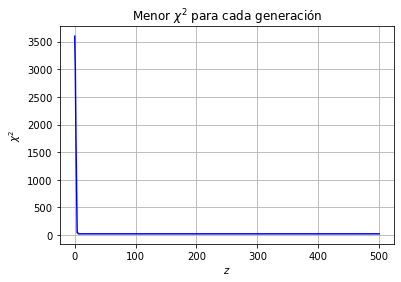

In [ ]:
funciones_finales = recu[0]
chis_finales = recu[1]
print(funciones_finales)
print(f"Menor chi^2: {recu[1][-1]}")
#print(recu[1])

z_chis= np.linspace(0, generaciones_evaluar, generaciones_evaluar + 1)
plt.xlabel('$ z $')
plt.ylabel('$ \chi^2 $')
plt.title('Menor $\chi^2$ para cada generación')
plt.plot(z_chis,chis_finales, color = 'blue')
plt.grid(True)
plt.show()

In [ ]:
#Graficando la función teórica

#Parámetros
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_k = 1 - omega_0

omega_m = 1 - omega_k - omega_l - omega_r

#Creamos la función teórica
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

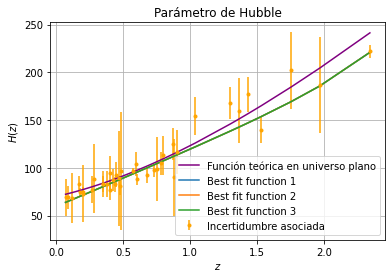

In [ ]:
best_fit = []
for string in funciones_finales:
    a= pasar_a_funcion(string)
    best_fit.append(a)

yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z) $')
plt.title('Parámetro de Hubble')

omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Función teórica en universo plano')
plt.plot(z, best_fit[0](z), label= 'Best fit function 1')
plt.plot(z, best_fit[1](z), label= 'Best fit function 2')
plt.plot(z, best_fit[2](z), label= 'Best fit function 3')
#plt.plot(z, best_fit[3](z), label= 'Best fit function 4')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Incertidumbre asociada')
plt.legend()
plt.grid(True)
plt.show()


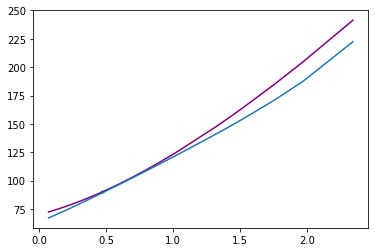

In [ ]:
def mejor_fit(x):
    return 3.177+(x+1)*57.906+((x**x)/0.258)-(x+1/(x**x))

plt.plot(array_z, H_t(array_z), color = 'purple', label='Función teórica en universo plano')
plt.plot(z, mejor_fit(z), label= 'Best fit function 1')